<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs_on_Multiple_timescale_dynamics/blob/main/Examples/pinns_on_van_der_pol_bvp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss: 32.495140075683594
Epoch 1000, Loss: 39.40918731689453
Epoch 2000, Loss: 16.240447998046875
Epoch 3000, Loss: 14.950610160827637
Epoch 4000, Loss: 5.871588706970215
Epoch 5000, Loss: 14.64846420288086
Epoch 6000, Loss: 1.3380755186080933
Epoch 7000, Loss: 1.8046619892120361
Epoch 8000, Loss: 3.5513668060302734
Epoch 9000, Loss: 4.695645332336426
Epoch 10000, Loss: 1.4271559715270996
Epoch 11000, Loss: 0.46124422550201416
Epoch 12000, Loss: 5.326632499694824
Epoch 13000, Loss: 0.8277724385261536
Epoch 14000, Loss: 0.6958624124526978
Epoch 15000, Loss: 0.7773627042770386
Epoch 16000, Loss: 2.4648194313049316
Epoch 17000, Loss: 1.5146960020065308
Epoch 18000, Loss: 1.3367037773132324
Epoch 19000, Loss: 0.45983701944351196
Epoch 20000, Loss: 0.9386655688285828
Epoch 21000, Loss: 0.5910865664482117
Epoch 22000, Loss: 1.1950857639312744
Epoch 23000, Loss: 0.5358901619911194
Epoch 24000, Loss: 1.878331184387207
Epoch 25000, Loss: 0.17836105823516846
Epoch 26000, Loss: 2.0070855

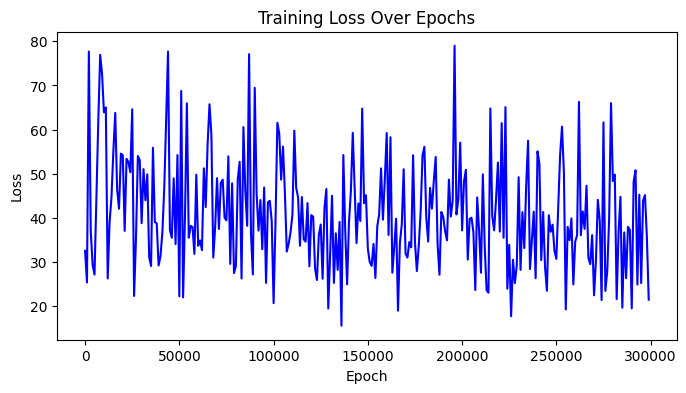

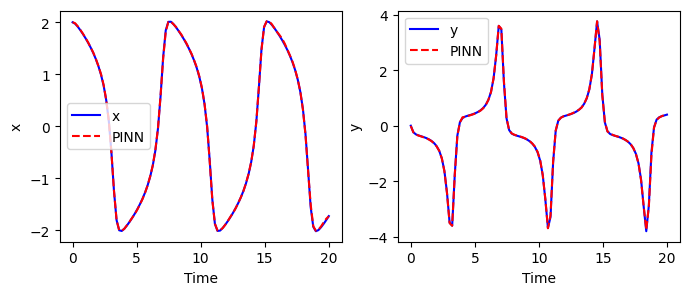

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# define ODEs
def VanDerPol(y, t, epsilon):
    x, y = y
    dxdt =  (y - (1/3) * x**3 + x)
    dydt = - epsilon * x
    return [dxdt, dydt]

'''
y0 = [0.002, 0.0]
t = np.linspace(0, 120, 100)
epsilon = -0.1
'''
y0 = [2, 0]
t = np.linspace(0, 20, 100)
epsilon = 1/100
#epsilon = 2
# solve ODEs
x_real, y_real = odeint(VanDerPol, y0, t, args=(epsilon,)).T
# tranform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)

'''
def input_transform(t_tensor):
    sin_cos_features = [torch.sin(n * t_tensor) for n in range(1, 3)] + \
                       [torch.cos(n * t_tensor) for n in range(1, 3)] + \
                       [-torch.sin(n * t_tensor) for n in range(1, 3)]
    return torch.cat([t_tensor] + sin_cos_features, dim=1)
'''
def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, t):
        t = input_transform(t)
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


def loss_func(model, t_tensor, x_real, y_real, x0, y0, x_T, y_T, epsilon, random_points=10):

    t_tensor.requires_grad = True
    pred = model(t_tensor)
    x_pred, y_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]

    residual1 = dx_dt - y_pred - x_pred + (1/3) * x_pred**3
    residual2 = dy_dt + epsilon * x_pred
    init_loss = torch.square(x_pred[0] - x0) + torch.square(y_pred[0] - y0)
    physics_loss = torch.mean(residual1**2 + residual2**2)
    #data_loss = torch.mean((pred_x - x_real)**2 + (pred_y - y_real)**2)
    random_indices = torch.randint(0, x_real.shape[0], (random_points,))
    data_loss = torch.mean((x_pred[random_indices] - x_real[random_indices])**2 +
                           (y_pred[random_indices] - y_real[random_indices])**2)

    boundary_loss = torch.square(x_pred[-1] - x_T) + torch.square(y_pred[-1] - y_T)
    #adjust weights
    total_loss = physics_loss + 0.01*init_loss + 0.01*boundary_loss + 10*data_loss

    #total_loss = data_loss
    return total_loss


if __name__=='__main__':
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_values = []
    epoch_num = 300000
    for epoch in range(epoch_num):
      loss = loss_func(model, t_tensor, x_real_tensor, y_real_tensor, y0[0], y0[1], x_real[-1], y_real[-1], epsilon, random_points=10)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f'Epoch {epoch}, Loss: {loss.item()}')
      loss_values.append(loss.item())

    plt.figure(figsize=(8, 4))
    plt.plot(range(0, epoch_num, 1000), loss_values[:epoch_num//1000], 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

    # model evaluation
    model.eval()
    with torch.no_grad():
        x_pred, y_pred = model(t_tensor).numpy().T

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(t, x_real, 'b-', label='x')
    plt.plot(t, x_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(t, y_real, 'b-', label='y')
    plt.plot(t, y_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

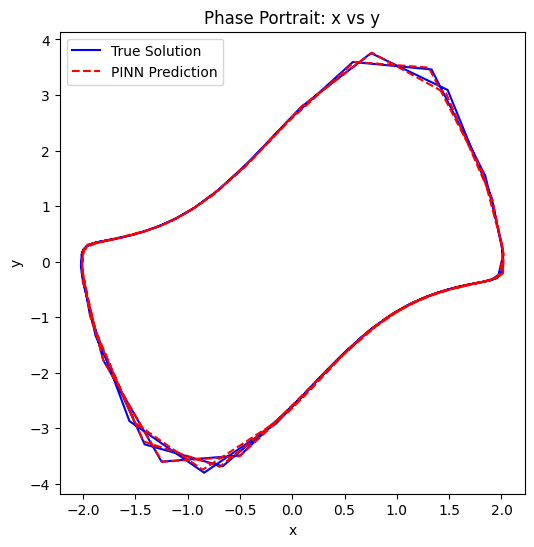

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(x_real, y_real, 'b-', label='True Solution')
plt.plot(x_pred, y_pred, 'r--', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Portrait: x vs y')
plt.legend()
plt.show()

In [ ]:
print(epsilon)

2
